In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import tensorflow as tf
from tensorflow import keras

from IPython.display import Image

import os
from shutil import copyfile, move, rmtree
from tqdm import tqdm
import h5py

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import InputLayer, Input
from tensorflow.keras.layers import Conv2D, Dense, Flatten, Dropout, Activation
from tensorflow.keras.layers import BatchNormalization, Reshape, MaxPooling2D, GlobalAveragePooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

In [2]:
print(tf.__version__)

1.14.0


# Preparing Data

* First, we will split dataframe containing class identification into train and dev set.
* Make directories for both train and dev sets with separate folders for each class (cactus/non-cactus image) inside.

In [3]:
df = pd.read_csv('../input/aerial-cactus-identification/train.csv')
test_dir = '../input/aerial-cactus-identification/test/test/'
print('Dataset contains {} images, where {} images contain cactus'.format(df.shape[0], 
                                                                          df['has_cactus'].value_counts()[0]))
print('Test set oontains {} images'.format(len(os.listdir(test_dir))))

Dataset contains 17500 images, where 4364 images contain cactus
Test set oontains 4000 images


In [4]:
#We will leave 15k images (14-15%) for validation
train_df = df[:15000]
dev_df = df[15000:]

In [5]:
#Copy train images in separate directory with 2 folders inside 
#for cactus(true) and non-cactus(false) images
input_train = '../input/aerial-cactus-identification/train/train/'
train_dir = '../sorted_train/'

os.mkdir(train_dir)
os.mkdir(train_dir + 'true')
os.mkdir(train_dir + 'false')

for idx, row in train_df.iterrows():
    if row['has_cactus'] == 1:
        copyfile(input_train + row['id'], train_dir + 'true/' + row['id'])
    else:
        copyfile(input_train + row['id'], train_dir + 'false/' + row['id'])

In [6]:
#Copy validation images in separate directory with 2 folders inside 
#for cactus(true) and non-cactus(false) images
dev_dir = '../sorted_dev/'

os.mkdir(dev_dir)
os.mkdir(dev_dir + 'true')
os.mkdir(dev_dir + 'false')

for idx, row in dev_df.iterrows():
    if row['has_cactus'] == 1:
        copyfile(input_train + row['id'], dev_dir + 'true/' + row['id'])
    else:
        copyfile(input_train + row['id'], dev_dir + 'false/' + row['id'])

Cactus image


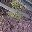

In [7]:
input_train = '../input/aerial-cactus-identification/train/train/'
print('Cactus image' if train_df.iloc[777,1] == 1 else 'Non-cactus image')
Image(os.path.join(input_train,train_df.iloc[777,0]),width=250,height=250)


### Creating Generators for Datasets

In [8]:
batch_size = 64
input_shape = (32, 32, 3)
num_classes = 2

* For training set we apply horizontal and vertical flips

In [9]:
#Generator of train images
train_datagen = ImageDataGenerator(rescale=1/255., 
                                  horizontal_flip=True,
                                  vertical_flip=True)

train_generator = train_datagen.flow_from_directory(directory=train_dir, 
                                              class_mode='binary', 
                                              batch_size=batch_size, 
                                              target_size=(32,32), 
                                              shuffle=True)

#Generator of validation images
dev_datagen = ImageDataGenerator(rescale=1/255.)

dev_generator = dev_datagen.flow_from_directory(directory=dev_dir, 
                                                class_mode='binary', 
                                                batch_size=batch_size, 
                                                target_size=(32,32))

Found 15000 images belonging to 2 classes.
Found 2500 images belonging to 2 classes.


# CNN Model

In [10]:
dropout_dense_layer = 0.6

model = Sequential()
model.add(Conv2D(32, (3,3), input_shape=input_shape))
model.add(BatchNormalization())
model.add(Activation('relu'))

model.add(Conv2D(32, (3, 3)))
model.add(BatchNormalization())
model.add(Activation('relu'))

model.add(Conv2D(32, (3,3)))
model.add(BatchNormalization())
model.add(Activation('relu'))

model.add(MaxPooling2D(pool_size=(2, 2)))


model.add(Conv2D(64, (3,3)))
model.add(BatchNormalization())
model.add(Activation('relu'))

model.add(Conv2D(64, (3,3)))
model.add(BatchNormalization())
model.add(Activation('relu'))

model.add(Conv2D(64, (3,3)))
model.add(BatchNormalization())
model.add(Activation('relu'))

model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(128, (3,3)))
model.add(BatchNormalization())
model.add(Activation('relu'))


model.add(Flatten())
model.add(Dense(1024,activation='relu'))
model.add(Dropout(dropout_dense_layer))

model.add(Dense(256,activation='relu'))
model.add(Dropout(dropout_dense_layer))

model.add(Dense(1,activation='sigmoid'))

In [11]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 30, 30, 32)        896       
_________________________________________________________________
batch_normalization (BatchNo (None, 30, 30, 32)        128       
_________________________________________________________________
activation (Activation)      (None, 30, 30, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 28, 28, 32)        9248      
_________________________________________________________________
batch_normalization_1 (Batch (None, 28, 28, 32)        128       
_________________________________________________________________
activation_1 (Activation)    (None, 28, 28, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 26, 26, 32)        9

In [12]:
model.compile(loss='binary_crossentropy', optimizer=keras.optimizers.Adam(lr=0.001), metrics=['accuracy'])

callbacks = [EarlyStopping(monitor='val_loss', patience=25),
             ModelCheckpoint(filepath='best_model.h5', monitor='val_loss', save_best_only=True)]

# Training

In [13]:
epochs=50
history=model.fit_generator(train_generator, epochs=epochs, \
                            validation_data=dev_generator, shuffle=True, verbose=1, callbacks=callbacks)

Epoch 1/50
235/235 [==============================] - 10s 43ms/step - loss: 0.1354 - acc: 0.9489 - val_loss: 2.2916 - val_acc: 0.2600
Epoch 2/50
235/235 [==============================] - 6s 26ms/step - loss: 0.0737 - acc: 0.9723 - val_loss: 0.5797 - val_acc: 0.8148
Epoch 3/50
235/235 [==============================] - 6s 26ms/step - loss: 0.0567 - acc: 0.9811 - val_loss: 1.1651 - val_acc: 0.7788
Epoch 4/50
235/235 [==============================] - 6s 26ms/step - loss: 0.0414 - acc: 0.9866 - val_loss: 0.0515 - val_acc: 0.9856
Epoch 5/50
235/235 [==============================] - 6s 25ms/step - loss: 0.0415 - acc: 0.9855 - val_loss: 0.2396 - val_acc: 0.9400
Epoch 6/50
235/235 [==============================] - 6s 26ms/step - loss: 0.0332 - acc: 0.9896 - val_loss: 0.0552 - val_acc: 0.9796
Epoch 7/50
235/235 [==============================] - 6s 26ms/step - loss: 0.0302 - acc: 0.9908 - val_loss: 0.0719 - val_acc: 0.9728
Epoch 8/50
235/235 [==============================] - 6s 26ms/step -

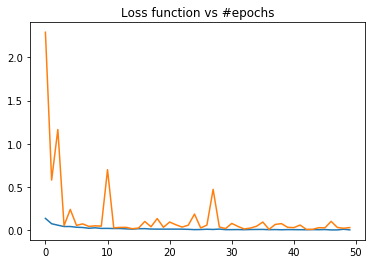

In [14]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss function vs #epochs')
plt.show()

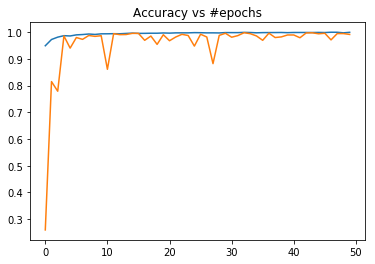

In [15]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Accuracy vs #epochs')
plt.show()

In [16]:
model.load_weights("best_model.h5")

# Making Predictions and Creating a Submission

In [17]:
#Generator for test images
test_dir = '../input/aerial-cactus-identification/test/'

test_datagen = ImageDataGenerator(
    rescale=1. / 255)

test_generator = test_datagen.flow_from_directory(
    directory=test_dir,
    target_size=(32,32),
    batch_size=1,
    class_mode='binary',
    shuffle=False
)

Found 4000 images belonging to 1 classes.


In [18]:
#Making Predictions
pred = model.predict_generator(test_generator,verbose=1) 
pred_binary = [0 if value<0.50 else 1 for value in pred]  

4000/4000 [==============================] - 11s 3ms/step


In [ ]:
#Creating Submission
csv_file = open("sample_submission_cnn.csv","w")
csv_file.write("id,has_cactus\n")
for filename, prediction in zip(test_generator.filenames, pred_binary):
    name = filename.split("/")[1].replace(".tif","")
    csv_file.write(str(name)+","+str(prediction)+"\n")
csv_file.close()